In [1]:
%matplotlib widget
import numpy as np
import obspy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
import types
import pickle
from location.compute_backazimuths import compute_backazimuths
from figures.figures import plot_backazimuths_on_imagery, transform_imagery, get_station_coordinates, get_station_grid_locations

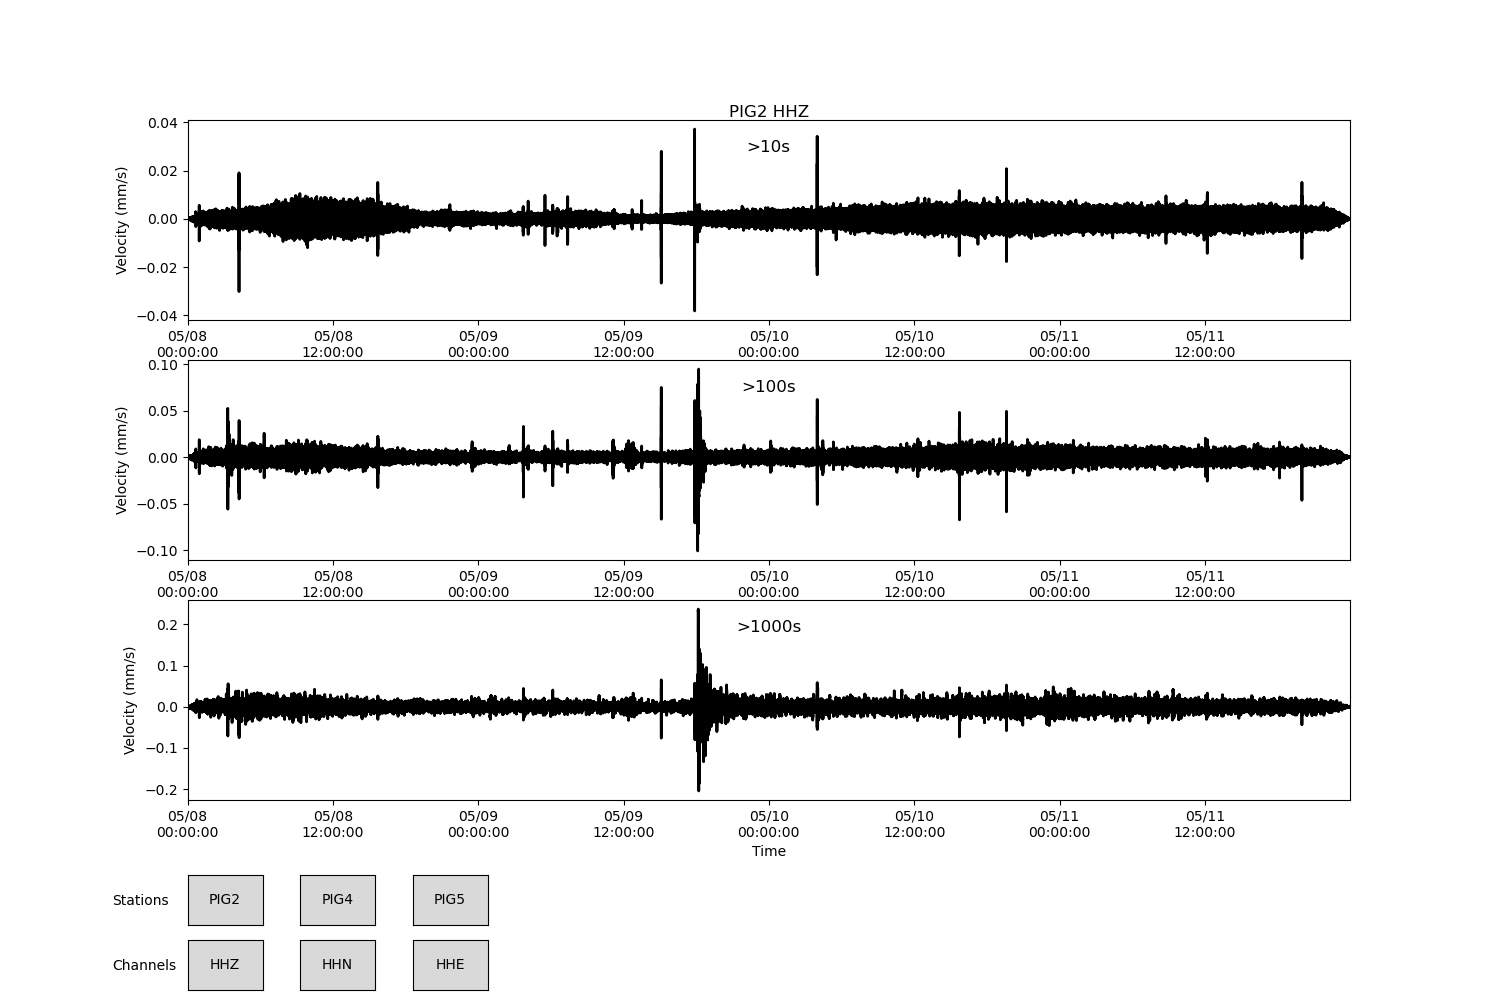

In [2]:
'''

Manually pick events that occur within the time window constrained by imagery

'''

# get data
st_10s = obspy.read("data/MSEED/may_8-11_velocity_10s_downsampled.MSEED")
st_100s = obspy.read("data/MSEED/may_8-11_velocity_100s_downsampled.MSEED")
st_1000s = obspy.read("data/MSEED/may_8-11_velocity_1000s_downsampled.MSEED")

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8)
window_end = obspy.UTCDateTime(2012,5,11,23,59)
data_10s_dict = {}
data_100s_dict = {}
data_1000s_dict = {}
for tr in st_10s:
    key = tr.stats.station+tr.stats.channel
    data_10s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_100s:
    key = tr.stats.station+tr.stats.channel
    data_100s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_1000s:
    key = tr.stats.station+tr.stats.channel
    data_1000s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_10s[1].times(type="matplotlib")

# define object for updating data when buttons are pressed
class metadata:
    station = "PIG2"
    channel = "HHZ"
    
    def select_channel(self,channel):
        def clicked(event):
            self.channel = channel
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
    def select_station(self,station):
        def clicked(event):
            self.station = station
            ax[0].get_lines()[0].set_ydata(data_10s_dict[self.station+self.channel])
            ax[1].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[2].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[0].set_title(self.station+" "+self.channel+"\n\n>10s",y=0.8)
            for axis in ax:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))
    
# make plot
fig,ax = plt.subplots(3,1,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)

# take care of arrival time storage
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)

# plot the data
ax[0].plot(t,data_10s_dict["PIG2HHZ"], lw=2,color='k')
ax[0].set_title("PIG2 HHZ\n\n>10s",y=0.8)
ax[1].plot(t,data_100s_dict["PIG2HHZ"], lw=2,color='k')
ax[1].set_title(">100s",y=0.8)
ax[2].plot(t,data_1000s_dict["PIG2HHZ"], lw=2,color='k')
ax[2].set_title(">1000s",y=0.8)

# make instances of the widget
column0 = metadata()

for axis in ax:
    axis.set_ylabel("Velocity (mm/s)")
    axis.set_xlabel("Time")
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M:%S'))
    axis.set_xlim([t[0],t[-1]])
ax[2].get_shared_x_axes().join(ax[2],ax[0])
ax[2].get_shared_x_axes().join(ax[2],ax[1])

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_station("PIG2"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_station("PIG4"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_station("PIG5"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_channel("HHZ"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_channel("HHN"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_channel("HHE"))
plt.text(-4,0.4,"Channels")

# make pick handling
class picks:
    start_time = []
    end_time = []
    event_windows = []
    def picker(self):
        def clicked(event):
            if plt.get_current_fig_manager().toolbar.mode != '': return
            if event.button == 1:
                self.start_time = matplotlib.dates.num2date(event.xdata)
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='g',linestyle='--')
            if event.button == 3:
                self.end_time = matplotlib.dates.num2date(event.xdata)
                self.event_windows.append([self.start_time,self.end_time])
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='r',linestyle='--')
                np.save('outputs/detections_new.npy',self.event_windows,allow_pickle=True)
        return clicked
    
detections = picks()
cid = fig.canvas.mpl_connect('button_press_event', detections.picker())

plt.show()

In [ ]:
''' 

Calculate backazimuths for all manually picked events

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 30
l.slide = 5
l.stations = ["PIG2","PIG4","PIG5"]
l.network = "XC"

# load and sort catalog
detection_times = np.load('outputs/detections.npy',allow_pickle=True)
sort_indices = np.argsort(detection_times[:,0])
l.detection_times = detection_times[sort_indices]

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.01,1]
l.fs = 100

# specify paths to data and me tadata
#l.data_path = "data/MSEED/no_IR/"
#l.xml_path = "data/XML/"
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.filename = "outputs/event_backazimuths_" + '_'.join(l.stations) + "_" + l.pca_correction + "_pca_" + l.centroid + "_centroid"
l.n_procs = 10

# run the backazimuth code
b = compute_backazimuths(l)

# save the output
baz_file = open(l.filename + ".pickle", "wb")
pickle.dump(b, baz_file)
baz_file.close()

In [ ]:
'''

Plot the locations of all the detected events

'''

# load the results of polarization analysis
baz_file = open("outputs/event_backazimuths_PIG2_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# get backazimuths of detected events
backazimuths = b.backazimuths
big_event_backazimuth = backazimuths[12]

# get station locations and array centroids
station_lon_lat_coords = get_station_coordinates("data/XML/")
station_grid_coords = get_station_grid_locations(station_lon_lat_coords,"epsg:3245")
array_centroid = np.mean(station_grid_coords,axis=0)

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
transform_imagery(file,'epsg:3245')

# set where to split the distribution and which color to use for each
colors = ["#7570b3","#d95f02"]

# make the figure
plot_backazimuths_on_imagery(backazimuths,big_event_backazimuth,array_centroid,station_grid_coords,colors)